In [1]:
import numpy as np
import pickle
import project_path
import os
from model.neuron_metadata import *
from model.data_accessor import get_data_file_abs_path
from model.neural_model import NeuralModel
from util.plot_util import *
neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json(get_data_file_abs_path('chem.json'))
N = neuron_metadata_collection.get_size()


# Concrete Example

In [2]:
def compare_Vth_slope_with_simulation(obs_neuron):
  
  model = NeuralModel(neuron_metadata_collection)
  model.init_kunert_2017()
  stim_neuron = "AWAR"
  stim_neuron_id = neuron_metadata_collection.get_id_from_name(stim_neuron)
  obs_neuron_id = neuron_metadata_collection.get_id_from_name(obs_neuron)
  
  # Precompute the Vth slope with math.
  cur_I_ext = np.zeros(N)
  model.cur_I_ext = cur_I_ext
  model.compute_Vth()

  A_inv = np.linalg.inv(model.A)
  # Original unit is mV / arbs. If change to mv / nA, need to be mv / 10000 arbs.
  vth_slope = -A_inv[obs_neuron_id, stim_neuron_id] * 10000
  
  print("Vth slope for %s is %.2f" % (obs_neuron, vth_slope))
  
  # Get the Vths of various I's with math
  Is = []
  Vths = []
  for I_nA in np.arange(0, 3, 1):
    cur_I_ext = np.zeros(N)
    # nA to arbs = *10,000
    cur_I_ext[stim_neuron_id] = I_nA * 10000
    model.cur_I_ext = cur_I_ext
    model.compute_Vth()
    Vth = model.Vth[obs_neuron_id]
    Is.append(I_nA)
    Vths.append(Vth)
    print ("I = %.2f (nA), Vth = %.2f (mV)" % (I_nA, Vth))
    if len(Vths) > 1:
      print("Slope to previous = %.2f" % ((Vth-Vths[-2])/(I_nA-Is[-2])))

  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
  ax.plot(Is, Vths)
  ax.set_ylabel("%s Vth (mV)" % obs_neuron)
  ax.set_xlabel("%s Injected current (nA))" % stim_neuron)
  fig.show()

Vth slope for AWAL is 1545.72
I = 0.00 (nA), Vth = -3.27 (mV)
I = 1.00 (nA), Vth = 1542.45 (mV)
Slope to previous = 1545.72
I = 2.00 (nA), Vth = 3088.17 (mV)
Slope to previous = 1545.72


/home/stephen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


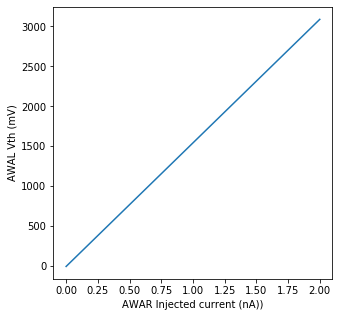

In [3]:
compare_Vth_slope_with_simulation("AWAL")

# Extreme slopes (mV / nA) per neuron classes

In [5]:
import pdb
model = NeuralModel(neuron_metadata_collection)
model.init_kunert_2017()
cur_I_ext = np.zeros(N)
model.cur_I_ext = cur_I_ext
model.compute_Vth()

A_inv = np.linalg.inv(model.A)
k = 5

def get_slope_for_neuron(obs_neuron_id):
  stim_neuron_id = neuron_metadata_collection.get_id_from_name("AWAR")
  # Original unit is mV / arbs. If change to mv / nA, need to be mv / 10000 arbs.
  return -A_inv[obs_neuron_id, stim_neuron_id] * 10000

for neuron_type in [NeuronType.SENSORY, NeuronType.INTERNEURON, NeuronType.MOTOR]:
  neuron_ids = neuron_metadata_collection.get_neuron_ids_by_neuron_type(neuron_type)
  slopes = [get_slope_for_neuron(neuron_id) for neuron_id in neuron_ids]
  sorted_idxs = np.argsort(slopes)
  bot_k_idxs = sorted_idxs[:k]
  top_k_idxs = sorted_idxs[:-k-1:-1]
  print("Bottom %d slopes for neuron type %s" % (k, neuron_type))
  for i in range(k):
    nidx = bot_k_idxs[i]
    nid = neuron_ids[nidx]
    slope = slopes[nidx]
    neuron_name = neuron_metadata_collection.get_metadata(nid).name
    print("%s: %.4f" % (neuron_name, slope))

  print("Top %d slopes for neuron type %s" % (k, neuron_type))
  for i in range(k):
    nidx = top_k_idxs[i]
    nid = neuron_ids[nidx]
    slope = slopes[nidx]
    neuron_name = neuron_metadata_collection.get_metadata(nid).name
    print("%s: %.4f" % (neuron_name, slope))
  

Bottom 5 slopes for neuron type NeuronType.SENSORY
IL2DL: 0.0000
PLNL: 0.0000
ALNR: 0.0000
PLNR: 0.0000
PVDR: 0.0000
Top 5 slopes for neuron type NeuronType.SENSORY
AWAR: 3397.7952
AWAL: 1545.7174
ASIR: 354.5968
ASIL: 288.4044
ASGR: 175.4903
Bottom 5 slopes for neuron type NeuronType.INTERNEURON
BDUR: 0.0000
BDUL: 0.0000
PVNR: 0.0000
AIMR: 0.0000
RIAL: 0.0000
Top 5 slopes for neuron type NeuronType.INTERNEURON
AIZR: 435.1823
AIAR: 405.4229
AIAL: 269.7285
AIZL: 98.6035
AINL: 60.9640
Bottom 5 slopes for neuron type NeuronType.MOTOR
HSNL: 0.0000
HSNR: 0.0000
VD12: 0.0000
RMFR: 0.0000
SMBVL: 0.0064
Top 5 slopes for neuron type NeuronType.MOTOR
RMGR: 17.6738
RMHR: 7.4491
RMGL: 6.8165
RMHL: 4.0734
SMBDR: 1.3547
